# Sportsbetting Project Bundesliga

This Notebook contains the development of a machine learning model to predict future Bundesliga games. The goal is to pass the algorithm two team names (i.e. Home Team and Away Team) to get the probability of the outcome of the game. The Idea is to create a vector for each Team, which includes selected features like goals scored, average possession etc. Those team-vectors will be applied to predict the outcome of future matches.

# Setup

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 50)
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras

#Plotting, Graphs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# fetching data from website 
import requests
import bs4
import lxml
from bs4 import BeautifulSoup

# Load and select Data
Mostly from **FBREF.com**, an incredible informative website. The website holds different tables with a variety of statistics, we will fetch the most important features step by step and attach them to a FeatureTable. Since I played soccer for my whole life, the importance of a feature will be evaluated by myself as of now, but later on we will use feature selection methods to see which features really impact the outcome, and which features maybe even worsen the accuracy of the model. To be able to choose the most relevant features, we have to make sure to create a broad dataset in the beginning to not miss out on potential features and an increase in accuracy. 

I downloaded the data from the mentioned website and saved those as a .csv file. To automate this process we could use methods like "TheBeautifulSoup", which fetches the most recent stats on the fly. However, Since the website is complex and saving the data as .csv simplifies the data preprocessing, I spend the extra minutes each week to update the most recent stats.

In [2]:
# First, The League Table
LeagueTable = pd.read_csv('LeagueTable.csv')
LeagueTable.head()

,Rk,Squad,MP,W,D,L,GF,GA,GDiff,Pts,xG,xGA,xGDiff,xGDiff/90,Last 5,Attendance
0,1,Bayern Munich,18,13,3,2,53,25,28,42,39.0,23.6,15.4,0.86,W L W W W,NaN
1,2,RB Leipzig,18,10,5,3,31,17,14,35,32.7,16.8,15.9,0.88,W L D W L,2000.0
2,3,Leverkusen,18,9,5,4,32,18,14,32,23.5,18.5,5.1,0.28,L D L W L,671.0
3,4,Wolfsburg,18,8,8,2,27,19,8,32,26.5,22.9,3.7,0.20,L D D W W,1144.0
4,5,M'Gladbach,18,8,7,3,35,28,7,31,31.1,23.9,7.2,0.40,W W D W W,1068.0


In [3]:
# Selecting the most important Features and adding them to the FeatureTable
FeatureTable = LeagueTable[['Squad', 'GF', 'GA', 'xG', 'xGA', 'Last 5']]
FeatureTable = FeatureTable.rename(columns={'Squad': 'Team', 'Last 5': 'Form'})
FeatureTable = FeatureTable.sort_values('Team', ignore_index=True)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form
0,Arminia,14,29,12.8,29.4,L W D W L
1,Augsburg,19,27,17.4,29.4,W L L L W
2,Bayern Munich,53,25,39.0,23.6,W L W W W
3,Dortmund,35,26,37.6,20.6,W W D L L
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W


In [4]:
# Second, the Shooting Stats
ShootingStats = pd.read_csv('ShootingStats.csv')
#ShootingStats.head()

In [5]:
# Again, adding the most important Features to be Featuretable
ShootingStats = ShootingStats[['SoT', 'SoT%', 'G/SoT', 'Dist']]
frames = [FeatureTable, ShootingStats] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0


In [6]:
#Third, the Passing Stats
PassingStats = pd.read_csv('PassingStats.csv')
#PassingStats.head()

In [7]:
# Again, adding the most important Features to be Featuretable
PassingStats = PassingStats[['KP', 'Cmp%', '3-Jan', 'PPA', 'CrsPA', 'Prog']]
PassingStats = PassingStats.rename(columns={'3-Jan': 'P_FT'})
frames = [FeatureTable, PassingStats] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709


In [8]:
#Adding another passing statistic
PassingStats2 = pd.read_csv('PassingStats2.csv')
#PassingStats2.head()

In [9]:
# Again, adding the most important Features to be Featuretable
PassingStats2 = PassingStats2[['TB', 'Sw', 'Crs']]
frames = [FeatureTable, PassingStats2] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249


In [10]:
#Adding goal creation statistics
GoalCreation = pd.read_csv('GoalCreation.csv')
#GoalCreation.head()

In [11]:
# Again, adding the most important Features to be Featuretable
GoalCreation = GoalCreation[['GCA', 'PassLive', 'PassDead', 'Drib']]
frames = [FeatureTable, GoalCreation] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206,57,42,3,4
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4


In [12]:
# Adding Defensive stats
DefensiveStats = pd.read_csv('DefensiveStats.csv')
#DefensiveStats.head()

In [13]:
# Again, adding the most important Features to be Featuretable
DefensiveStats = DefensiveStats[['%', 'Att 3rd']]
DefensiveStats = DefensiveStats.rename(columns={'%': 'SP%'})
frames = [FeatureTable, DefensiveStats] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,34.4,813
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206,57,42,3,4,36.6,646
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,32.8,712


In [14]:
#Adding goal creation statistics
PossessionStats = pd.read_csv('PossessionStats.csv')
#PossessionStats.head()

In [15]:
# Again, adding the most important Features to be Featuretable
PossessionStats = PossessionStats[['Poss', '3-Jan', 'CPA', 'Rec%', 'MV']]
PossessionStats = PossessionStats.rename(columns={'3-Jan': 'C_FT'})
frames = [FeatureTable, PossessionStats] # Building a 'frame' with both tables to be able to easily join add them together
FeatureTable = pd.concat(frames, axis=1)
FeatureTable.head()

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,C_FT,CPA,Rec%,MV
0,Arminia,14,29,12.8,29.4,L W D W L,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531,44.3,158,39,82.1,45.15
1,Augsburg,19,27,17.4,29.4,W L L L W,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486,43.1,174,40,79.2,104.28
2,Bayern Munich,53,25,39.0,23.6,W L W W W,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,34.4,813,62.7,316,111,86.7,891.40
3,Dortmund,35,26,37.6,20.6,W W D L L,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206,57,42,3,4,36.6,646,62.2,336,107,88.7,615.20
4,Eint Frankfurt,35,27,30.9,24.9,W W W D W,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,32.8,712,52.5,212,86,80.7,186.20


### Abbreviation Definition

- **GF** = Goals for  $\qquad\qquad\qquad\;\;\;$  **Prog** = Completed Pass in PA
- **GA** = Goals against           $\qquad\qquad\;\;\;\;\;$  **TB** = Trough Ball            
- **xG** = Expected Goals  $\qquad\quad\quad\;\;\;$  **GCA** = Goal creating Actions 
- **xGA** = Expected Goals against     $\qquad$  **PassLive** = Passes leading to a goal          
- **Form** = Current Form   $\qquad\quad\;\;\;\;\;$  **PassDead** = Dead Passes leading to a Goal  
- **SoT** = Shots on Target   $\qquad\quad\;\;\;\;\;$  **Drib** Dribblings leading to a Goal 
- **SoT%** = SoT / Shots   $\qquad\quad\;\;\;\;\;$ **SP** Successfull Pressure percentage
- **G/SoT** = Goals per SoT   $\qquad\quad\;\;\;\;\;$ **C_FT** Carries into final Third 
- **Dist** = Avg goal distance   $\qquad\quad\;\;\;\;\;$ **Att 3rd** Tackles in Attacking 3rd
- **KP** = Key Passes   $\qquad\quad\qquad\;\;\;\;\;$ **Poss** Possession (% of Passes attempted)
- **Cmp%** = Pass completion %   $\qquad\quad\;\;\;\;\;$ **C_FT** Carries into final Third   
- **P_FT** = Passes into final Third   $\qquad\quad\;\;$  **CPA** Carries into Penalty Area
- **PPA** = Passes Penalty Area (PA)   $\qquad$  **Rec%** Passes received percentage
- **CrsPA** = Crosses into PA   $\qquad\quad\;\;\;\;\;$  **MV** Market Value
- **Crs** = Crosses   $\qquad\quad\qquad\;\;\;\;\;$  **Sw** = Switches (over 40 yards)

# Feature Engineering
Now that the Feature Table is complete, we need to take care of formalities, like the categorical values of "Form". This Feature represents the current form of the team. A good way to represent this column in a single numerical value, is to add 1 for a Win and subtract 1 for a Loss (a Draw will be disregarded and counts as 0). So the current form will be in the range of -5 to 5.

In [16]:
type(FeatureTable['Form'])

pandas.core.series.Series

In [17]:
FormTeam = FeatureTable['Form']
for team in range(len(FeatureTable.Form)):
    wins = FormTeam.iloc[team].count('W') 
    losses = FormTeam.iloc[team].count('L')
    Form = FormTeam.iloc[team] = wins - losses
Form

1

So, the updated FeatureTable looks as follows

In [18]:
FeatureTable[0:18]

,Team,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,C_FT,CPA,Rec%,MV
0,Arminia,14,29,12.8,29.4,0,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531,44.3,158,39,82.1,45.15
1,Augsburg,19,27,17.4,29.4,-1,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486,43.1,174,40,79.2,104.28
2,Bayern Munich,53,25,39.0,23.6,3,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,34.4,813,62.7,316,111,86.7,891.40
3,Dortmund,35,26,37.6,20.6,0,102,36.8,0.33,16.0,209,85.1,734,239,35,866,38,315,206,57,42,3,4,36.6,646,62.2,336,107,88.7,615.20
4,Eint Frankfurt,35,27,30.9,24.9,4,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,32.8,712,52.5,212,86,80.7,186.20
5,Freiburg,33,29,28.3,27.9,2,86,38.7,0.33,16.2,167,76.0,416,131,45,558,6,269,228,49,31,5,2,26.3,632,44.8,187,63,82.4,111.70
6,Hertha BSC,24,32,23.0,25.1,-2,77,35.5,0.27,17.4,153,79.7,476,131,43,599,10,357,241,35,28,1,0,29.7,617,52.8,238,81,83.7,251.93
7,Hoffenheim,28,30,29.2,31.8,0,85,39.2,0.27,16.9,157,79.7,534,149,45,676,13,291,208,49,29,2,5,33.8,606,50.2,227,72,84.0,238.33
8,Koln,15,31,18.1,31.2,-2,50,30.7,0.26,16.2,117,75.0,380,97,37,469,8,234,203,23,12,2,1,29.6,533,42.3,141,30,80.9,101.81
9,Leverkusen,32,18,23.5,18.5,-2,91,38.2,0.32,18.3,184,83.1,649,150,42,697,17,312,226,53,33,7,4,35.7,636,61.4,289,75,87.1,343.45


# First Investigations
Now that the FeatureTable is complete, it makes sense to take a look about the general performances of the teams and which features seem to have the most significant impact on the outcome of the game. 

## Homeadvantage
First, it is interesting to see if the "Homeadvantage" takes place in this season. To investigate this, we will use a Dataset from "Football-data.co.uk", which contains the whole matchplan including the outcome.

In [19]:
MatchPlan = pd.read_csv('D1.csv')
MatchPlan.tail()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,...,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
157,D1,23/01/2021,14:30,Leverkusen,Wolfsburg,0,1,A,0,1,A,10,8,4,4,13,7,6,2,1,1,0,0,2.05,3.60,...,3.75,3.25,2.17,3.82,3.82,2.06,3.64,3.48,1.66,2.20,1.66,2.35,1.74,2.37,1.66,2.22,-0.25,1.84,2.09,1.85,2.08,1.87,2.19,1.80,2.08
158,D1,23/01/2021,14:30,Mainz,RB Leipzig,3,2,H,2,2,D,10,12,4,5,13,16,3,9,2,4,0,0,7.50,5.00,...,5.00,1.36,8.50,5.15,1.44,7.94,4.80,1.40,1.66,2.20,1.68,2.31,1.69,2.37,1.64,2.25,1.25,2.04,1.89,2.05,1.88,2.12,1.93,2.01,1.86
159,D1,23/01/2021,17:30,Hertha,Werder Bremen,1,4,A,1,2,A,18,7,10,5,16,12,7,1,2,3,0,0,2.10,3.50,...,3.30,3.50,2.30,3.50,3.89,2.17,3.27,3.55,2.20,1.66,2.23,1.71,2.26,1.76,2.14,1.70,-0.25,1.85,2.08,1.86,2.07,1.95,2.18,1.84,2.02
160,D1,24/01/2021,14:30,Schalke 04,Bayern Munich,0,4,A,0,1,A,14,32,4,14,5,9,3,7,1,1,0,0,16.00,8.50,...,8.00,1.17,17.00,8.90,1.20,13.89,8.16,1.17,1.25,4.00,1.25,4.20,1.29,4.35,1.25,3.90,2.25,1.97,1.96,1.96,1.94,2.04,2.01,1.93,1.93
161,D1,24/01/2021,17:00,Hoffenheim,FC Koln,3,0,H,2,0,H,13,13,4,4,8,13,6,9,2,3,0,0,1.75,3.75,...,3.80,4.60,1.80,4.01,5.05,1.75,3.78,4.69,1.80,2.00,1.83,2.06,1.88,2.15,1.78,2.03,-0.75,1.99,1.94,1.98,1.94,2.01,1.95,1.97,1.90


In [20]:
MatchPlan = MatchPlan[['HomeTeam', 'AwayTeam', 'FTR']] #FTR = Full-Time-Result
MatchPlan.tail()

,HomeTeam,AwayTeam,FTR
157,Leverkusen,Wolfsburg,A
158,Mainz,RB Leipzig,H
159,Hertha,Werder Bremen,A
160,Schalke 04,Bayern Munich,A
161,Hoffenheim,FC Koln,H


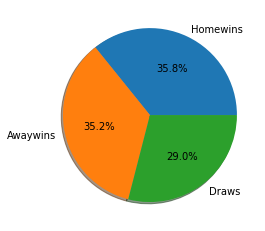

In [21]:
wins_home = len(MatchPlan[MatchPlan['FTR'] == 'H'])
home_perc = wins_home/len(MatchPlan)*100
wins_away = len(MatchPlan[MatchPlan['FTR'] == 'A'])
away_perc = wins_away/len(MatchPlan)*100
draws = len(MatchPlan[MatchPlan['FTR'] == 'D'])
draw_perc = draws/len(MatchPlan)*100
ratio = [home_perc, away_perc, draw_perc]

labels = 'Homewins', 'Awaywins', 'Draws'
fig1, ax1 = plt.subplots()
ax1.pie(ratio, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

All in all, there does not seem to be a home advantage this season. Still, experiences show that homeadvantages usually take place; this season maybe not so much because of the Pandemic. There could be still a performance difference when looking at the individual teams.

In [22]:
## Making sure the team names from both the MatchPlan and the FeatureTable are the same
teams = MatchPlan[['HomeTeam', 'AwayTeam']]
teams = teams.replace('Bielefeld', 'Arminia')
teams = teams.replace('FC Koln', 'Koln')
teams = teams.replace('Ein Frankfurt', 'Eint Frankfurt')
teams = teams.replace('Hertha', 'Hertha BSC')
teams = teams.replace('Mainz', 'Mainz 05')
teams = teams.replace('M\'gladbach', 'M\'Gladbach')

MatchPlan['HomeTeam'] = teams['HomeTeam'] # Implement changes into the MatchPlan Table
MatchPlan['AwayTeam'] = teams['AwayTeam']
MatchPlan[0:10]

,HomeTeam,AwayTeam,FTR
0,Bayern Munich,Schalke 04,H
1,Eint Frankfurt,Arminia,D
2,Koln,Hoffenheim,A
3,Stuttgart,Freiburg,A
4,Union Berlin,Augsburg,A
5,Werder Bremen,Hertha BSC,A
6,Dortmund,M'Gladbach,H
7,RB Leipzig,Mainz 05,H
8,Wolfsburg,Leverkusen,D
9,Hertha BSC,Eint Frankfurt,A


In [23]:
# Calculating number of home wins, away wins and draws
wins = pd.DataFrame(columns=('Team', 'HW', 'AW', 'D'))

TeamHome = MatchPlan.groupby('HomeTeam')
TeamAway = MatchPlan.groupby('AwayTeam')
wins.Team = FeatureTable['Team']

# Home wins and draws as home team
for team in range(len(wins.Team)):
    wins.HW[team] = TeamHome.FTR.sum().values[team]
    wins.D[team] = TeamHome.FTR.sum().values[team]
    wins.HW[team] = wins.HW[team].count('H')
    wins.D[team] = wins.D[team].count('D')

#Away wins and draws as away team
for team in range(len(wins.Team)):
    wins.AW[team] = TeamAway.FTR.sum().values[team]
    dummy = TeamAway.FTR.sum().values[team]
    dummy = dummy.count('D')
    wins.AW[team] = wins.AW[team].count('A')
    wins.D[team] = wins.D[team] + dummy

wins.head()

,Team,HW,AW,D
0,Arminia,4,1,2
1,Augsburg,3,3,4
2,Bayern Munich,6,7,3
3,Dortmund,4,5,2
4,Eint Frankfurt,3,4,9


<Figure size 936x504 with 0 Axes>

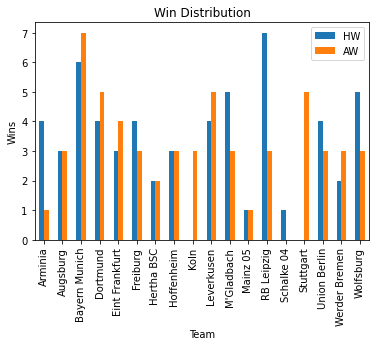

In [24]:
plt.figure(figsize=(13,7))
wins.plot.bar(x='Team', y=['HW', 'AW'])
plt.title('Win Distribution')
plt.ylabel('Wins')
plt.show()

In contrast to the overall similar Home and Away performance shown in the pie chart, the performances of the individual teams seem to differ in some cases, as shown above. With extrem cases like Arminia Bielefeld, Stuttgart or RB Leipzig, it might make sense to include some sort of distinction between home and away performances. However, as long as there can no clear Homeadvantage be observed, this idea might be postponed for the future.

## Feature Correlation

It also makes sense to see which of our features seem to have to biggest impact, and which of them we might be even able to drop. Having the wrong features can negatively impact the accuracy of the model later on. If we included all the features found on the website mentioned above (FBREF), we could easily get up to over 100 features. The main task is to find the most valueable features for the Training set. Since this is a very important step, we might keep including as many feature as possible and use different techiques to sort them out. 

**Note - as of now we have 29 Features. When using ALL features, the model (Logistic Regression) did not converge to a solution. This underlines the importance of Feature Selection**

First, let's have a look how some of the feature are correlated to each other.

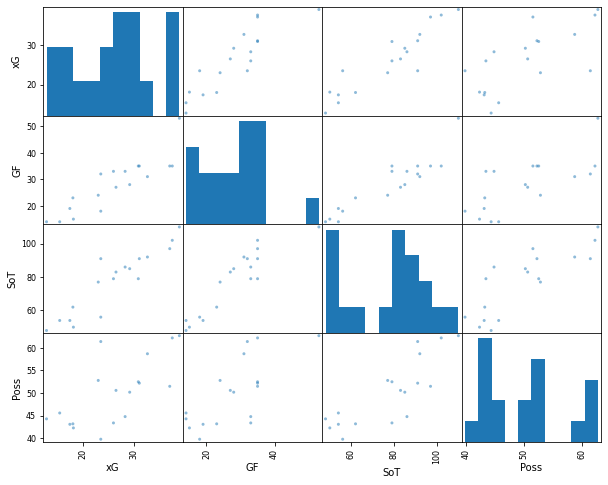

In [57]:
from pandas.plotting import scatter_matrix

features = ["xG", "GF", "SoT", "Poss"]
scatter_matrix(FeatureTable[features], figsize=(10, 8))
plt.show()

After using different features to investigate the correlation, a lot of times we could see a positive linear correlation between the chosen features (more shots on target = higher xG value, ..). Since we have only 18 teams, we have only the same amount of datapoints, which seems pretty less. However, a correlation between the features is visible. With this in mind, we could think about dropping some redundant features; for example, GF and xG seem to have such a strong correlation (which makes sense) that we could thinking about dropping the goals scored GF and only keep the expected goals xG. 

To have a better understanding of all the features and their correlation, we will create a heatmap

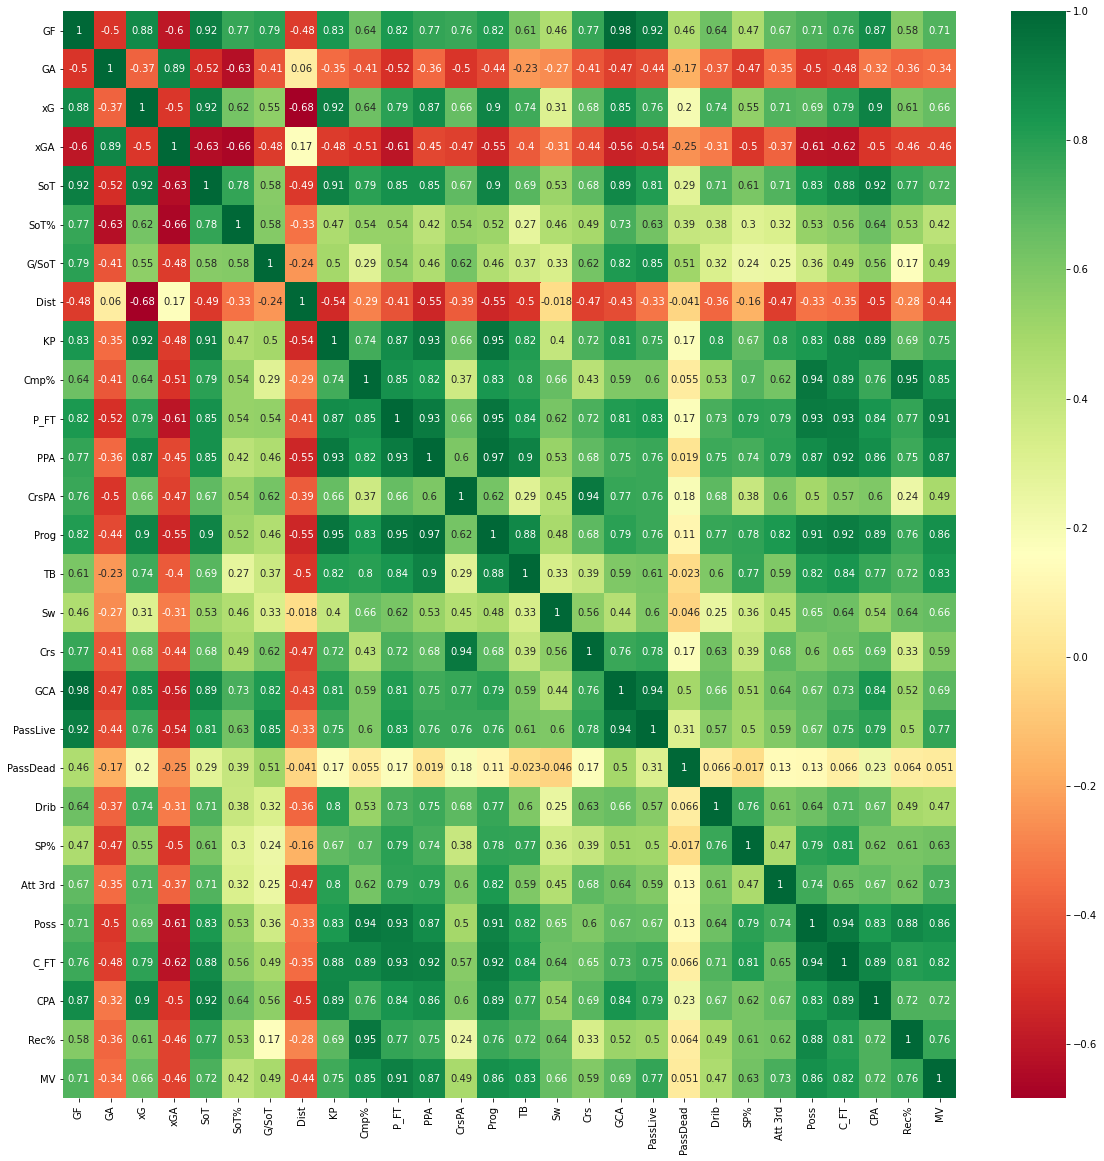

In [26]:
# get correlations of each feature in dataset
dataFeatures = FeatureTable.drop(['Team'], axis=1)
corrMat = dataFeatures.corr()
plt.figure(figsize=(20, 20))
# plot heat map
g = sns.heatmap(corrMat, annot=True, cmap='RdYlGn')

The Heatmap shows A LOT of correlations between the features. Green is the indicator for strong correlations. After looking at this data, we can reduce the features and probably can cut them in half. Having highle correlated features will reduce the accuracy of the model. First, we can start sorting out one of the features that's correlation is over **90%** to another feature. For convenience, the abbreviation definition is described below.

For example, Pass completion percentage (Cmp%) is highly correlated to Passes Received percentage (Rec%), so we can remove one of these attributes. To decide which ones to remove, we will have a look at the relation of all independend variables (features) to the outcome (full-time-result). The ones with a lower relationship to the outcome will be removed. First, we need to set up the completed FeatureTable including the matchdays and their outcomes, since we have not included the full time result (depentend variable) yet. 

### Abbreviation Definition

- **GF** = Goals for  $\qquad\qquad\qquad\;\;\;$  **Prog** = Completed Pass in PA
- **GA** = Goals against           $\qquad\qquad\;\;\;\;\;$  **TB** = Trough Ball            
- **xG** = Expected Goals  $\qquad\quad\quad\;\;\;$  **GCA** = Goal creating Actions 
- **xGA** = Expected Goals against     $\qquad$  **PassLive** = Passes leading to a goal          
- **Form** = Current Form   $\qquad\quad\;\;\;\;\;$  **PassDead** = Dead Passes leading to a Goal  
- **SoT** = Shots on Target   $\qquad\quad\;\;\;\;\;$  **Drib** Dribblings leading to a Goal 
- **SoT%** = SoT / Shots   $\qquad\quad\;\;\;\;\;$ **SP** Successfull Pressure percentage
- **G/SoT** = Goals per SoT   $\qquad\quad\;\;\;\;\;$ **C_FT** Carries into final Third 
- **Dist** = Avg goal distance   $\qquad\quad\;\;\;\;\;$ **Att 3rd** Tackles in Attacking 3rd
- **KP** = Key Passes   $\qquad\quad\qquad\;\;\;\;\;$ **Poss** Possession (% of Passes attempted)
- **Cmp%** = Pass completion %   $\qquad\quad\;\;\;\;\;$ **C_FT** Carries into final Third   
- **P_FT** = Passes into final Third   $\qquad\quad\;\;$  **CPA** Carries into Penalty Area
- **PPA** = Passes Penalty Area (PA)   $\qquad$  **Rec%** Passes received percentage
- **CrsPA** = Crosses into PA   $\qquad\quad\;\;\;\;\;$  **MV** Market Value
- **Crs** = Crosses   $\qquad\quad\qquad\;\;\;\;\;$  **Sw** = Switches (over 40 yards)

# Setting up the Matchday Configuration
As already discussed in the very beginning, each team and their vector of feature values will be implemented into the Matchdays table. After this set up is finished, we will be able to set up some models and train the algorithm.

In [27]:
#MatchPlan.head()

In [28]:
#FeatureTable.head()

In [29]:
def FeatureToMatchDayTable(matchplan, featuretable):
    '''Function which uses the Feature- and MatchPlan Table as an input to output the setup for the Matchday games'''

    # Loop through "HomeTeam" column and attach row from the FeatureTable according to the team
    df_home = pd.DataFrame()

    for team in range(len(matchplan.HomeTeam)):
        for team2 in range(len(featuretable.Team)):
            if (matchplan.HomeTeam[team] == featuretable.Team[team2]):
                df_home = df_home.append(featuretable.iloc[[team2]], ignore_index=True)
    
    # Append Hometeam stats to matchdays
    frames = [matchplan, df_home.drop(['Team'], axis=1)]
    df = pd.concat(frames, axis=1)
    df.tail()
    
    # same for away team stats
    df_away = pd.DataFrame()

    for team in range(len(matchplan.AwayTeam)):
        for team2 in range(len(featuretable.Team)):
            if (matchplan.AwayTeam[team] == featuretable.Team[team2]):
                df_away = df_away.append(featuretable.iloc[[team2]], ignore_index=True)
    
    # Attach Awayteam stats to matchdays to finish up the FeatureTable
    frames = [df, df_away.drop(['Team'], axis=1)]
    JoinedTables = pd.concat(frames, axis=1)
    return JoinedTables

In [33]:
Feature_Table = FeatureToMatchDayTable(MatchPlan, FeatureTable).head()

In [34]:
# Since y is still a categorical value, we need to transform the column into numerical values
def transformResult(row):
    '''Converts results (H,A or D) into numeric values'''
    if(row.FTR == 'H'):      # Win HomeTeam = 1
        return 1
    elif(row.FTR == 'A'):    # Win AwayTeam = -1
        return -1
    else:
        return 0             # Draw = 0

In [35]:
Feature_Table["FTR"] = Feature_Table.apply(lambda row: transformResult(row),axis=1)
Feature_Table.head()

,HomeTeam,AwayTeam,FTR,GF,GA,xG,xGA,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,...,Form,SoT,SoT%,G/SoT,Dist,KP,Cmp%,P_FT,PPA,CrsPA,Prog,TB,Sw,Crs,GCA,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,C_FT,CPA,Rec%,MV
0,Bayern Munich,Schalke 04,1,53,25,39.0,23.6,3,110,38.5,0.43,16.5,229,84.0,855,244,65,907,30,384,319,95,77,5,5,...,-3,54,27.1,0.24,17.7,141,77.0,362,112,20,511,16,231,137,24,15,3,1,30.9,544,45.6,163,44,82.1,165.80
1,Eint Frankfurt,Arminia,0,35,27,30.9,24.9,4,79,35.3,0.32,16.0,181,76.3,569,153,47,709,18,209,249,59,32,7,4,...,0,48,31.2,0.25,18.7,107,75.2,393,86,24,436,8,273,155,19,18,0,1,30.4,531,44.3,158,39,82.1,45.15
2,Koln,Hoffenheim,-1,15,31,18.1,31.2,-2,50,30.7,0.26,16.2,117,75.0,380,97,37,469,8,234,203,23,12,2,1,...,0,85,39.2,0.27,16.9,157,79.7,534,149,45,676,13,291,208,49,29,2,5,33.8,606,50.2,227,72,84.0,238.33
3,Stuttgart,Freiburg,-1,35,29,37.1,27.6,0,97,34.0,0.30,17.2,212,79.5,540,179,48,730,20,227,228,58,34,3,6,...,2,86,38.7,0.33,16.2,167,76.0,416,131,45,558,6,269,228,49,31,5,2,26.3,632,44.8,187,63,82.4,111.70
4,Union Berlin,Augsburg,-1,33,23,26.0,19.0,0,79,39.3,0.38,17.4,145,74.6,436,100,45,533,11,225,206,60,43,5,2,...,-1,54,32.3,0.33,18.0,123,76.3,365,106,31,496,12,223,169,28,20,2,0,29.9,486,43.1,174,40,79.2,104.28


This is the featureTable that will be used to train the model. Right now, the model would not converge to a solution, since the features have not been touched yet. In fact, the **f1-score is at only 38.89%**, which is more than bad. 

# Feature Importance with respect to the outcome of the game

As already discussed, we need to reduce the feature size significantly since many features are related which leads to a performance decrease of the model. To investigate which features can be removed, we will observe their individual relation with the outcome of the game. When those feature selection methods are applied, it is interesting to know if scaling the data makes any difference **(Update: feature scaling was applied but the result was exaclty the same, which makes sense since scaling the data should not change the correlation)**. We will use two feature selection methods (**Univariante Selection and Pearson Correlation**)

Instead of using the whole dataset, we will seperate the data of the last 3 matchdays to evaluate the accuracy of the model using each of the 4 feature selection results.

In [36]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

X = Feature_Table.drop(['HomeTeam', 'AwayTeam', 'FTR'], axis=1)
y = Feature_Table['FTR']
#X.head()

## Univariante Selection

In [37]:
# Using f_classif instead of chi2 since we have negative values (FTR)
bestFeatures = SelectKBest(score_func=f_classif, k=10) 

fit = bestFeatures.fit(X, y)

In [38]:
X = pd.DataFrame(X, columns=X.columns) # numpy array to pd dataframe for next step

In [39]:
dfScores = pd.DataFrame(fit.scores_)                # Feature scores
dfColumns = pd.DataFrame(X.columns)                 # Feature names

In [40]:
# concat two dataframes for better visualization
Score_US = pd.concat([dfColumns, dfScores], axis=1)
Score_US.columns = ['Feature_US', 'Score_US'] #naming columns
Score_US = Score_US.sort_values(by=['Score_US'], ascending=False)
Score_US.head()

,Feature_US,Score_US
16,Sw,466.435821
28,MV,417.164854
30,GA,63.542857
17,Crs,23.112701
32,xGA,10.920930


## Pearson Correlation
The Pearson correlation can be computed easily with the .corr() method using pandas DataFrames. It is the most commen method used to investigate feature correlation for example.

In [41]:
corr_matrix = Feature_Table.corr()
corr_matrix = corr_matrix['FTR'].sort_values(ascending=False)
corr_matrix = pd.DataFrame(corr_matrix)
corr_matrix = corr_matrix.drop(['FTR'], axis=0)              # Dropping FTR row, which is 1 anyway
corr_matrix.columns = ['Score_P']
corr_matrix['Feature_P'] = corr_matrix.index   #Copy index column so we will be able to join two dataframes later on
corr_matrix = corr_matrix.reindex(columns=['Feature_P', 'Score_P'])  # Swap columns for better visibility
corr_matrix.head()

,Feature_P,Score_P
Crs,Crs,0.967132
P_FT,P_FT,0.928912
MV,MV,0.925851
Poss,Poss,0.897717
GA,GA,0.876126


The length of the pearson score vector is one row shorter than the invariant correlation vector. This is because the "Form" attribute is not included. This featzre was also not included in the heatmap, since the heatmap also uses the pearson correlation to determine the feature correlations.

Let's join the two scores together to see the difference.

In [42]:
#Join the two methods for better visibility
#dummy = [{'Score_P': 'dummy'}]
#corr_matrix = corr_matrix.append(dummy)       # append dummy variable since this vector has one row less

corr_matrix.reset_index(drop=True, inplace=True)      #Reindexing both dataframes
Score_US.reset_index(drop=True, inplace=True)

frames = [corr_matrix, Score_US] # Building a 'frame' with both tables to be able to easily join add them together
ScoreTotal = pd.concat(frames, axis=1)
ScoreTotal

,Feature_P,Score_P,Feature_US,Score_US
0,Crs,0.967132,Sw,466.435821
1,P_FT,0.928912,MV,417.164854
2,MV,0.925851,GA,63.542857
3,Poss,0.897717,Crs,23.112701
4,GA,0.876126,xGA,10.920930
5,CrsPA,0.868243,P_FT,9.255006
6,TB,0.839434,Form,8.000000
7,Prog,0.828204,CrsPA,5.482474
8,xGA,0.824067,Poss,4.377420
9,Att 3rd,0.816879,PassLive,3.445347


Looking at the korrelation between the features and the outcome, we can now make the next move and **remove all highly correlated features that do not have a significant relationship with the endresult y**. As visible, some features are evaluated pretty much the same with both methods, but other features seem to be different in their importance. So we investigate strongly correlated features and remove the one with the lowest correlation to the outcome. 

For example, Poss and PPA have a relation of 0.97, so we can remove one of them. Since Poss has a higher correlation to y, we will remove PPA. Applying those steps for all features, these are the ones that will be removed from the Dataset:

PPA, Crs, GCA, Rec%, Cmp, KP, CPA, C_FT, TB, P_FT, Prog, SoT, GF, GA

The question becomes if we remove GF or xG. Clearly GF has the highest correlation the the outcome, however, xG is the statistical average about how many goals a team should have scored, and the actual goals scored (GF) is just the standard devation of that average. Since this is the case, xG might be more accurate for future predictions, and we will remove the actual goals scored to avoid overfitting the training data. Same with xGA and GA.

In [43]:
FeatureTable2 = FeatureTable.drop(['PPA', 'Crs', 'GCA', 'Rec%', 'Cmp%', 'KP', 'CPA', 'C_FT', \
                                   'TB', 'P_FT', 'Prog', 'GF', 'GA', 'SoT'], axis=1)
FeatureTable2.head()

,Team,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV
0,Arminia,12.8,29.4,0,31.2,0.25,18.7,24,273,18,0,1,30.4,531,44.3,45.15
1,Augsburg,17.4,29.4,-1,32.3,0.33,18.0,31,223,20,2,0,29.9,486,43.1,104.28
2,Bayern Munich,39.0,23.6,3,38.5,0.43,16.5,65,384,77,5,5,34.4,813,62.7,891.40
3,Dortmund,37.6,20.6,0,36.8,0.33,16.0,35,315,42,3,4,36.6,646,62.2,615.20
4,Eint Frankfurt,30.9,24.9,4,35.3,0.32,16.0,47,209,32,7,4,32.8,712,52.5,186.20


To see the final correlations, another heat table

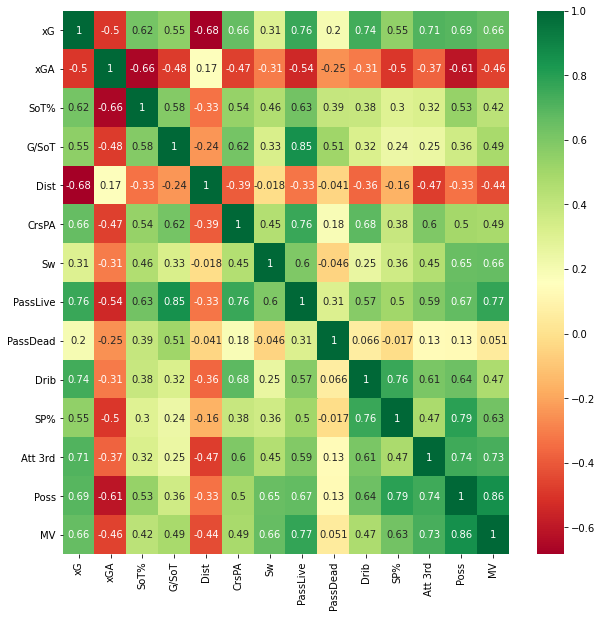

In [44]:
# get correlations of each feature in dataset
dataFeatures = FeatureTable2.drop(['Team'], axis=1)
corrMat = dataFeatures.corr()
plt.figure(figsize=(10, 10))
# plot heat map
k = sns.heatmap(corrMat, annot=True, cmap='RdYlGn')

**Note:** We were able to cut the numbers of features in half, however, since this is a continuing project, new features will be evaluated and maybe included. We still have many medium correlated features, and since we did not include a lot of defensive stats, we might to that as the project goes on. The more independent features, the better (as long as the features are correlated to y).

In [45]:
Feature_Table = FeatureToMatchDayTable(MatchPlan, FeatureTable2)
Feature_Table.head()

,HomeTeam,AwayTeam,FTR,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV
0,Bayern Munich,Schalke 04,H,39.0,23.6,3,38.5,0.43,16.5,65,384,77,5,5,34.4,813,62.7,891.40,15.4,39.9,-3,27.1,0.24,17.7,20,231,15,3,1,30.9,544,45.6,165.80
1,Eint Frankfurt,Arminia,D,30.9,24.9,4,35.3,0.32,16.0,47,209,32,7,4,32.8,712,52.5,186.20,12.8,29.4,0,31.2,0.25,18.7,24,273,18,0,1,30.4,531,44.3,45.15
2,Koln,Hoffenheim,A,18.1,31.2,-2,30.7,0.26,16.2,37,234,12,2,1,29.6,533,42.3,101.81,29.2,31.8,0,39.2,0.27,16.9,45,291,29,2,5,33.8,606,50.2,238.33
3,Stuttgart,Freiburg,A,37.1,27.6,0,34.0,0.30,17.2,48,227,34,3,6,33.1,669,51.5,103.45,28.3,27.9,2,38.7,0.33,16.2,45,269,31,5,2,26.3,632,44.8,111.70
4,Union Berlin,Augsburg,A,26.0,19.0,0,39.3,0.38,17.4,45,225,43,5,2,31.8,423,43.4,60.60,17.4,29.4,-1,32.3,0.33,18.0,31,223,20,2,0,29.9,486,43.1,104.28


In [46]:
Feature_Table["FTR"] = Feature_Table.apply(lambda row: transformResult(row),axis=1)
Feature_Table.head()

,HomeTeam,AwayTeam,FTR,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV,xG,xGA,Form,SoT%,G/SoT,Dist,CrsPA,Sw,PassLive,PassDead,Drib,SP%,Att 3rd,Poss,MV
0,Bayern Munich,Schalke 04,1,39.0,23.6,3,38.5,0.43,16.5,65,384,77,5,5,34.4,813,62.7,891.40,15.4,39.9,-3,27.1,0.24,17.7,20,231,15,3,1,30.9,544,45.6,165.80
1,Eint Frankfurt,Arminia,0,30.9,24.9,4,35.3,0.32,16.0,47,209,32,7,4,32.8,712,52.5,186.20,12.8,29.4,0,31.2,0.25,18.7,24,273,18,0,1,30.4,531,44.3,45.15
2,Koln,Hoffenheim,-1,18.1,31.2,-2,30.7,0.26,16.2,37,234,12,2,1,29.6,533,42.3,101.81,29.2,31.8,0,39.2,0.27,16.9,45,291,29,2,5,33.8,606,50.2,238.33
3,Stuttgart,Freiburg,-1,37.1,27.6,0,34.0,0.30,17.2,48,227,34,3,6,33.1,669,51.5,103.45,28.3,27.9,2,38.7,0.33,16.2,45,269,31,5,2,26.3,632,44.8,111.70
4,Union Berlin,Augsburg,-1,26.0,19.0,0,39.3,0.38,17.4,45,225,43,5,2,31.8,423,43.4,60.60,17.4,29.4,-1,32.3,0.33,18.0,31,223,20,2,0,29.9,486,43.1,104.28


##### Update: with those features the model performance went up to 44.4%, which is an increase in 6%. We still need a lot more relevant features to get up to a goal of 60%. The follwing section will be witnesses to the investigation of new features. 

# Further Feature Investigation

# Train-Test-Split

In [47]:
# Setting up X and y Data
X = Feature_Table.drop(['HomeTeam', 'AwayTeam', 'FTR'], axis=1) # Dropping Team names and FTR
y = Feature_Table['FTR']

In [48]:
X_test = X.iloc[-18:, :] #Last 2 Matchdays (18 games) as test data
y_test = y.iloc[-18:]

X_train = X.iloc[:-18, :] # Rest of Dataset as training data
y_train = y.iloc[:-18]

## Scaling the Data

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training Models

In [50]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [51]:
reg_clf = LogisticRegression(random_state=42)
reg_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

## Match predictions and Evaluation

In [52]:
y_pred = reg_clf.predict(X_test)
y_pred

array([ 0,  1,  1, -1, -1, -1, -1,  0,  1, -1, -1, -1, -1,  0, -1,  0, -1,
        0])

In [53]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test,reg_clf.predict(X_test))
score

0.4444444444444444

In [54]:
f1_score(y_test, y_pred, average='micro')

0.4444444444444444

In [55]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_test)

array([[5, 0, 5],
       [2, 1, 2],
       [1, 0, 2]])

In [56]:
result = Feature_Table.iloc[-18:, 0:3]
result['Pred'] = y_pred
result

,HomeTeam,AwayTeam,FTR,Pred
144,M'Gladbach,Werder Bremen,1,0
145,Hertha BSC,Hoffenheim,-1,1
146,Leverkusen,Dortmund,1,1
147,Mainz 05,Wolfsburg,-1,-1
148,Schalke 04,Koln,-1,-1
149,Augsburg,Bayern Munich,-1,-1
150,Arminia,Stuttgart,1,-1
151,Freiburg,Eint Frankfurt,0,0
152,RB Leipzig,Union Berlin,1,1
153,M'Gladbach,Dortmund,1,-1
